# Librerias

In [ ]:
#!pip install wandb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from xgboost import XGBClassifier
#from wandb.xgboost import wandb_callback
from sklearn.compose import ColumnTransformer
from xgboost import plot_importance
import lightgbm as lgb
import datetime

# Data

In [2]:
df = pd.read_csv("dataset_SCL.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


# Helper Functions



In [4]:
class CFG:
  def __init__(self):
    self.target = 'target'
    self.seed = 1313
    self.test_size = 0.1
    self.Kfold = 5
cfg = CFG()

In [5]:
def display_metrics(y_test, y_preds, y_prob):
  """
  Función que reporta las métricas a considerar
  en este caso de uso
  """

  # F1 Score
  print("===== F1 Score =====")
  f1 = f1_score(y_test, y_preds)
  print(f'Test Score: {f1:.3f}')

  # AUC Score
  print("===== AUC Score =====")
  auc = roc_auc_score(y_test, y_prob[:, 1])
  print(f'AUC Score: {auc:.3f}')
  
  # Confusion Matrix
  print("===== Confusion Matrix =====")  
  cm = confusion_matrix(y_test, y_preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
  disp.plot()
  plt.show()

  return f1, auc, cm

In [6]:
def log_wandb(run, f1, auc, test_preds, test_probs, model, X_train, y_train, X_test, y_test):
  """ Log métricas y gráficos en WandB"""

  # Metrics 
  run.summary["F1"] = f1
  run.summary["AUC"] = auc

  # Plots
  labels = ["no", "yes"]

  # ROC
  wandb.sklearn.plot_roc(y_test, test_probs, labels)

  # Confusion Matrix
  wandb.sklearn.plot_confusion_matrix(y_test, test_preds, labels)

  # Metrics
  wandb.sklearn.plot_summary_metrics(model, X_train, y_train, X_test, y_test)

In [7]:
import warnings

from sklearn.pipeline import Pipeline

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    
    
    # Get columns and bin edges
    def pair_bin_edges_columns(bins_edges, columns):
        all_edge_column = []
        for index in range(len(columns)):
            bin_edge = bins_edges[index]
            column = columns[index]
            
            pair_bin_edge = []
            # match consecutive bin edges together
            for first, second in zip(bin_edge, bin_edge[1:]):
                pair_bin_edge.append((first, second))
            
            bin_edge_column = [column +": ["+ str(edge[0]) +", "+ str(edge[1])+")"  for edge in pair_bin_edge]
            all_edge_column.extend(bin_edge_column)
        return all_edge_column
    
    
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            
            # For transformers that create bins
            if hasattr(trans, 'bin_edges_'):
                bins_edges = trans.bin_edges_
                pairs_edges_columns = pair_bin_edges_columns(bins_edges, column)
            if column is None:
                return []
            else:
                return [name + "__" + f for f in pairs_edges_columns]
        return [name + "__" + f for f in trans.get_feature_names(column)]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

# EDA

¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

In [ ]:
!pip install ydata_profiling

In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Insights

- Ausencia de variables numéricas: La mayoría (si no todas, son variables categóricas)
- Existen variables con valores únicos (los eliminaré). Podrian usarse para extraer información externa, pero ese no será el caso.
- Muchas de las variables categóricas tienen alta dimension, esto podría afectar a los modelos (Curse of Dimensionality). Es por esto que tendré que tomar medidas con respecto a esto (hash, pca, etc.)
- Por la misma razón (variables categóricas), es que creo que un modelo basado en árboles se ajustará mejor, es por esto que comenzaré por ahi.
- Si bien tenemos info de fecha, no es un problema secuencial (de series de tiempo), por lo que la estrategia de validación puede ser simple.

In [8]:
# Eliminar Variables Únicas
df.drop(labels = ["Ori-I", "Ori-O", "AÑO", "SIGLAORI"], axis = 1, inplace = True)

In [9]:
# Analizar el balance entre variables categóricas y el target
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
cat_cols

['Fecha-I',
 'Vlo-I',
 'Des-I',
 'Emp-I',
 'Fecha-O',
 'Vlo-O',
 'Des-O',
 'Emp-O',
 'DIANOM',
 'TIPOVUELO',
 'OPERA',
 'SIGLADES']

In [ ]:
# Balanceo variables categóricas
fig, axs = plt.subplots(3,3, figsize = (20,15))
fig.tight_layout()
i_col = 0
for i in range(3):
  for j in range(3):
    sns.countplot(data=df, x = cat_cols[i_col], ax=axs[i,j])
    axs[i,j].tick_params(labelrotation=45);
    i_col+=1

plt.subplots_adjust(left=0.1,
                  bottom=0.1,
                  right=0.9,
                  top=0.9,
                  wspace=0.4,
                  hspace=0.4)
fig.suptitle("Balance Variables Categóricas", fontsize=16);
plt.show()

# Parte 2. 
Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv 

In [11]:
df

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,Domingo,I,American Airlines,Miami
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,Lunes,I,American Airlines,Miami
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,Martes,I,American Airlines,Miami
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,Miercoles,I,American Airlines,Miami
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,Jueves,I,American Airlines,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SPJC,JAT,2017-12-22 15:41:00,400.0,SPJC,JAT,22,12,Viernes,I,JetSmart SPA,Lima
68202,2017-12-25 14:55:00,400,SPJC,JAT,2017-12-25 15:11:00,400.0,SPJC,JAT,25,12,Lunes,I,JetSmart SPA,Lima
68203,2017-12-27 14:55:00,400,SPJC,JAT,2017-12-27 15:35:00,400.0,SPJC,JAT,27,12,Miercoles,I,JetSmart SPA,Lima
68204,2017-12-29 14:55:00,400,SPJC,JAT,2017-12-29 15:08:00,400.0,SPJC,JAT,29,12,Viernes,I,JetSmart SPA,Lima


In [12]:
print(f"La información va desde {df['Fecha-I'].min()} hasta {df['Fecha-I'].max()}")

La información va desde 2017-01-01 00:15:00 hasta 2017-12-31 23:55:00


In [13]:
# 1. temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
# Hay sólo aun año asi que podemos aprovechar esto
# Es raro porque sólo hay info hasta el mes mayo

df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])

mask_1 = df["Fecha-I"].between(datetime.datetime(2016,12,15), datetime.datetime(2017,3,3))
mask_2 = df["Fecha-I"].between(datetime.datetime(2017,7,15), datetime.datetime(2017,7,31))
mask_3 = df["Fecha-I"].between(datetime.datetime(2017,9,11),  datetime.datetime(2017,9,30))

df["TAlta"] = 0
df.loc[(mask_1 | mask_2 | mask_3), "TAlta"] = 1

In [14]:
# Sanity Check
df[df["TAlta"]==1]

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,TAlta
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,Domingo,I,American Airlines,Miami,1
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,Lunes,I,American Airlines,Miami,1
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,Martes,I,American Airlines,Miami,1
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,Miercoles,I,American Airlines,Miami,1
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,Jueves,I,American Airlines,Miami,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49731,2017-09-29 17:37:00,253,SCTE,JAT,2017-09-29 18:02:00,253,SCTE,JAT,29,9,Viernes,N,JetSmart SPA,Puerto Montt,1
49732,2017-09-25 13:21:00,281,SCQP,JAT,2017-09-25 13:18:00,281,SCQP,JAT,25,9,Lunes,N,JetSmart SPA,Temuco,1
49733,2017-09-26 13:21:00,281,SCQP,JAT,2017-09-26 13:12:00,281,SCQP,JAT,26,9,Martes,N,JetSmart SPA,Temuco,1
49734,2017-09-27 13:00:00,281,SCQP,JAT,2017-09-27 13:02:00,281,SCQP,JAT,27,9,Miercoles,N,JetSmart SPA,Temuco,1


In [15]:
#2. dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])
df["Fecha-O"] = pd.to_datetime(df["Fecha-O"])
df["dif_min"] = (df["Fecha-O"] - df["Fecha-I"]).dt.total_seconds()/60


In [16]:
df["dif_min"]

0         3.0
1         9.0
2         9.0
3         3.0
4        -2.0
         ... 
68201    46.0
68202    16.0
68203    40.0
68204    13.0
68205     9.0
Name: dif_min, Length: 68206, dtype: float64

In [17]:
# 3. target atraso_15: 1 si dif_min > 15, 0 si no
df["target"] =  np.where(df['dif_min']>15, 1, 0)

In [18]:
# periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I.
df.set_index(df["Fecha-I"], inplace = True)

In [19]:
df['periodo_dia'] = np.nan

In [20]:
df.loc[df.between_time('05:00', '11:00').index, "periodo_dia"] = "mañana"
df.loc[df.between_time('12:00', '18:59').index, "periodo_dia"] = "tarde"
df.loc[df.between_time('19:00', '04:59').index, "periodo_dia"] = "noche"

In [21]:
df.reset_index(drop = True, inplace = True)

In [22]:
df

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,TAlta,dif_min,target,periodo_dia
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,Domingo,I,American Airlines,Miami,1,3.0,0,noche
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,Lunes,I,American Airlines,Miami,1,9.0,0,noche
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,Martes,I,American Airlines,Miami,1,9.0,0,noche
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,Miercoles,I,American Airlines,Miami,1,3.0,0,noche
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,Jueves,I,American Airlines,Miami,1,-2.0,0,noche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SPJC,JAT,2017-12-22 15:41:00,400.0,SPJC,JAT,22,12,Viernes,I,JetSmart SPA,Lima,0,46.0,1,tarde
68202,2017-12-25 14:55:00,400,SPJC,JAT,2017-12-25 15:11:00,400.0,SPJC,JAT,25,12,Lunes,I,JetSmart SPA,Lima,0,16.0,1,tarde
68203,2017-12-27 14:55:00,400,SPJC,JAT,2017-12-27 15:35:00,400.0,SPJC,JAT,27,12,Miercoles,I,JetSmart SPA,Lima,0,40.0,1,tarde
68204,2017-12-29 14:55:00,400,SPJC,JAT,2017-12-29 15:08:00,400.0,SPJC,JAT,29,12,Viernes,I,JetSmart SPA,Lima,0,13.0,0,tarde


# Pregunta 3 
¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
¿Qué variables esperarías que más influyeran en predecir atrasos?

In [23]:
df.MES.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [24]:
obs_cols = ["Des-I", "OPERA", "MES", "DIANOM", "TAlta", "TIPOVUELO"]

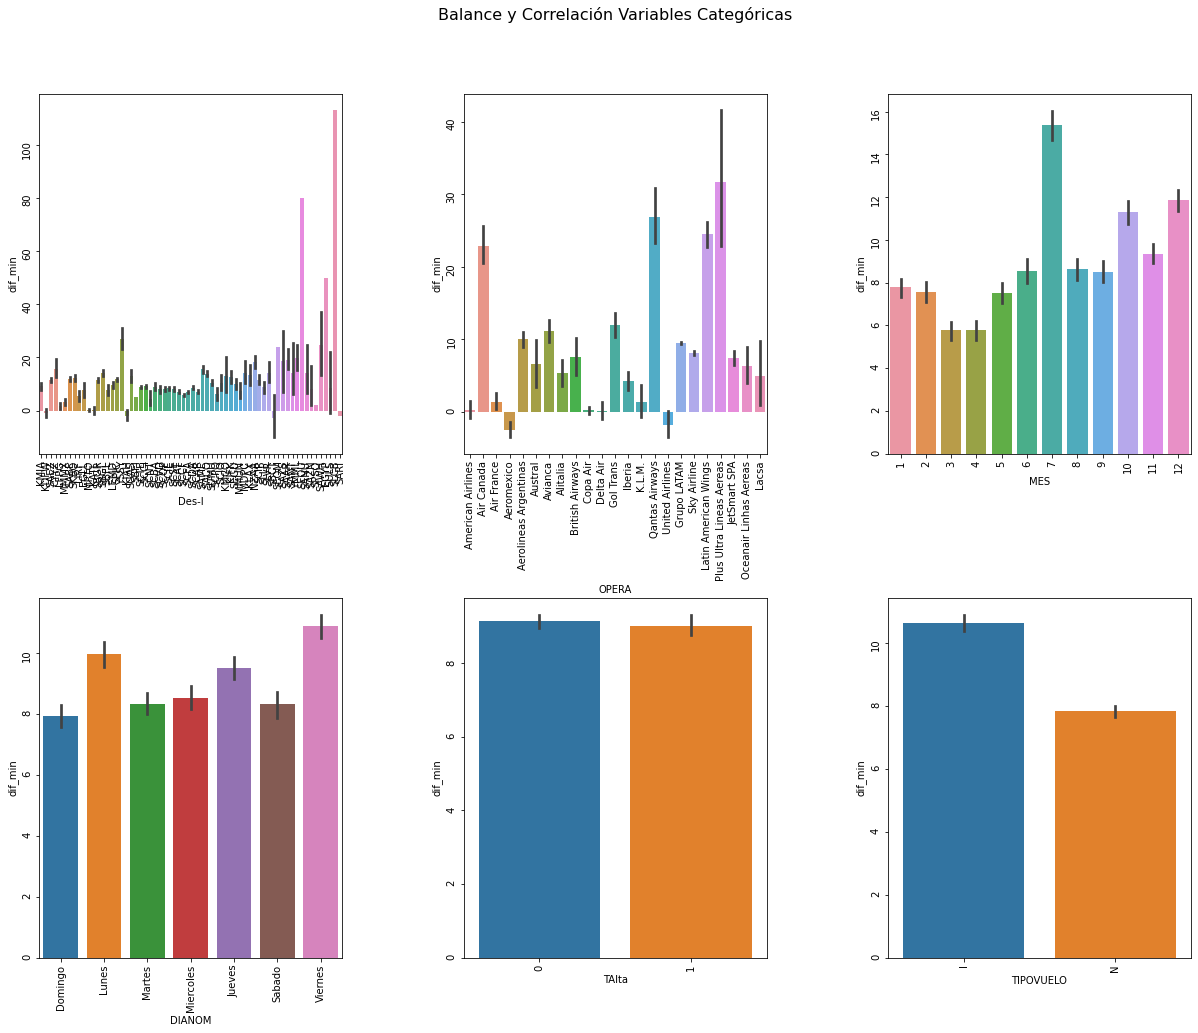

In [26]:
# Balanceo y Correlación con target
fig, axs = plt.subplots(2,3, figsize = (20,15))
fig.tight_layout()
i_col = 0
for i in range(2):
  for j in range(3):
    sns.barplot(data=df, y = "dif_min", ax=axs[i,j], x = obs_cols[i_col])
    axs[i,j].tick_params(labelrotation=90);
    i_col+=1

plt.subplots_adjust(left=0.1,
                  bottom=0.1,
                  right=0.9,
                  top=0.9,
                  wspace=0.4,
                  hspace=0.4)
fig.suptitle("Balance y Correlación Variables Categóricas", fontsize=16)
plt.show();

Pareciera que las variables que más afectan el tiempo de dealy:

- Des-I
- Aerolinea
- Mes
- Tipo Vuelo

<AxesSubplot:xlabel='target', ylabel='count'>

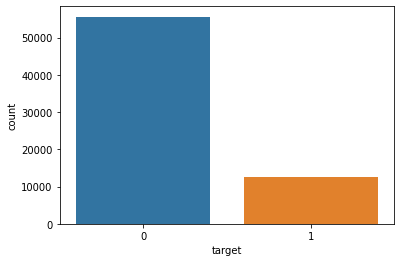

In [27]:
# Como se comporta el target
sns.countplot(data = df, x = 'target')

In [28]:
df.target.value_counts()

0    55592
1    12614
Name: target, dtype: int64

In [29]:
# DATA IMBALANCEADA!

# Prototyping

En la experimentación, utilizaremos la herramienta de experiment tracking `weight & bias`. No es estrictamente necesario dado que probablemente no probaré muchos modelos, pero sirve como demostración. El flujo de experimentación será algo como:

1. **Construir Baseline**: La idae es que sea un modelo simple y fácil de iterar. Ya que es un problema de *clasificación*, usaré `Regresión Logística`. Para esto pienso primero crear un baseline sólo utilizando las variables numéricas, para luego agregarles las categóricas.
2. **Complejizar Modelo**: Acá la idea es ver si agregandole complejidad a la solución podemos capturar de mejor forma los patrones que envuelven al problema. Para esto utilizaré modelos basados en boosteo de Árboles de decisión (XGBoost, LightGBM). Porque? Porque suelen entregar buenos resultados y tienen un buen nivel de explicabilidad, claramente podemos probar un montón de otros modelos más. 
3. **Feature Engineering**: Como último paso intentaré mejorar el modelo actual creando nuevas features que ayuden al modelo a converger de más rápido.

4. 😓**Ensemble**: Ensamblar modelos puede ser un paso ideal, pero en esta ocasión lo omitiré, ya que creo que el objetivo de esto no es tener el mejor performance posible, si no evaluar la resolución de problemas en un contexto de Machine Learning. 

> 🛑 Importante! Antes debemos escoger un método de evaluación y métricas a considerar.

> 🐝  **W&B** se puede aprovechar para experiment tracking, model versioning, report colaboration, hyperparameter tunning, etc. En este caso sólo lo utilizaremos para experiment tracking

> 🛑 Alerta! Recordemos que estamos en un problema con clase imbalanceada. Existen numerosas técnicas para esto (Undersampling, Oversampling, Cost Functions, etc.). No soy muy fan de las primeras dos, por lo que alteraré la función de costos agregandole mayor peso a la clase menor.

## 🐝 W&B🐝 Login 

In [ ]:
wandb.login(relogin=True)

## Evaluación

In [30]:
df

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,TAlta,dif_min,target,periodo_dia
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,Domingo,I,American Airlines,Miami,1,3.0,0,noche
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,Lunes,I,American Airlines,Miami,1,9.0,0,noche
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,Martes,I,American Airlines,Miami,1,9.0,0,noche
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,Miercoles,I,American Airlines,Miami,1,3.0,0,noche
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,Jueves,I,American Airlines,Miami,1,-2.0,0,noche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SPJC,JAT,2017-12-22 15:41:00,400.0,SPJC,JAT,22,12,Viernes,I,JetSmart SPA,Lima,0,46.0,1,tarde
68202,2017-12-25 14:55:00,400,SPJC,JAT,2017-12-25 15:11:00,400.0,SPJC,JAT,25,12,Lunes,I,JetSmart SPA,Lima,0,16.0,1,tarde
68203,2017-12-27 14:55:00,400,SPJC,JAT,2017-12-27 15:35:00,400.0,SPJC,JAT,27,12,Miercoles,I,JetSmart SPA,Lima,0,40.0,1,tarde
68204,2017-12-29 14:55:00,400,SPJC,JAT,2017-12-29 15:08:00,400.0,SPJC,JAT,29,12,Viernes,I,JetSmart SPA,Lima,0,13.0,0,tarde


In [31]:
# Elimino fechas e información de operación ya que no estará al momento de la inferencia
df.drop(labels = ['Fecha-I', 'Fecha-O', 'dif_min', 'Vlo-O', 'Des-O', 'Emp-O'], axis = 1, inplace = True)

In [32]:
# Features categóricas y numéricas
cat_cols = [col for col in df.columns if df[col].dtype == 'object' and col != 'target']
num_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'target']

### Metric

Nos encontramos con un problema de `clasificación`. La métrica más común es **Accuracy**, pero debido a que nos encontramos con un target imbalanceado, ésta no es adecuada.

Debido a que tampoco se ve muy claro si es más doloroso los falsos negativos o los falsos positivos, analizaré el **F1-Score** como métrica principal. Además también veré la matriz de confusión y el AUC.

### Test Split

In [33]:
# Paso 1: Fijar un conjunto de testeo (o hold-out)

# Features & Target
y = df.pop(cfg.target)
X = df.copy()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=cfg.test_size, random_state=cfg.seed, stratify = y)

# To DataFrame
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

#X_num = df[num_cols]
#X_cat = df[num_cat]



In [34]:
y_train.value_counts(normalize = True)

0    0.815053
1    0.184947
Name: target, dtype: float64

# Baseline: RandomForest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [42]:

# Logistic Regression
rf = RandomForestClassifier(class_weight='balanced', random_state=cfg.seed)

# Pipeline

# Numeric Transformer
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

# Categorical Transformer
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Feature Processor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", rf)]
)
# RandomSearch Grid
tf_param_grid = {
    "model__max_depth": [10, 50, 100, 500],
    "model__n_estimators": [50, 100, 500],
    #"model__min_weight_fraction_leaf" : np.logspace(-4, 4, 10)

}

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61385 entries, 40166 to 58693
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Vlo-I        61385 non-null  object
 1   Des-I        61385 non-null  object
 2   Emp-I        61385 non-null  object
 3   DIA          61385 non-null  int32 
 4   MES          61385 non-null  int32 
 5   DIANOM       61385 non-null  object
 6   TIPOVUELO    61385 non-null  object
 7   OPERA        61385 non-null  object
 8   SIGLADES     61385 non-null  object
 9   TAlta        61385 non-null  int32 
 10  periodo_dia  61385 non-null  object
dtypes: int32(3), object(8)
memory usage: 4.9+ MB


In [38]:
for col in X_train.columns:
  if col in cat_cols:
    X_train[col] = X_train[col].astype(str)
  if col in num_cols:
    X_train[col] = X_train[col].astype('int32')

In [44]:
r_search = RandomizedSearchCV(pipe, tf_param_grid, n_jobs=-1, verbose = 3, scoring='f1', cv = cfg.Kfold, random_state=cfg.seed)
r_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
print("Best parameter (CV score=%0.3f):" % r_search.best_score_)
print(r_search.best_params_)

In [56]:
test_preds = r_search.predict(X_test)
test_probs = r_search.predict_proba(X_test)
model = r_search.best_estimator_

===== F1 Score =====
Test Score: 0.416
===== AUC Score =====
AUC Score: 0.704
===== Confusion Matrix =====


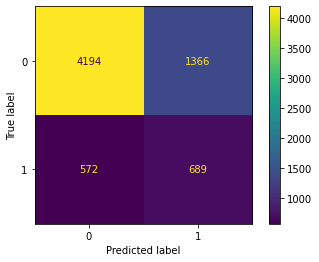

In [57]:
f1, auc, cm = display_metrics(y_test, test_preds, test_probs)

In [58]:
# Feature Importance
import sklearn
# Primero debo fitear el column transformer para obtener los nombres de las variables
X_temp = preprocessor.fit_transform(X_train)
feature_names = get_feature_names(preprocessor)

# Feature Importance
feature_importance = model['model'].feature_importances_

# Create DataFrame
feature_importance_data = pd.DataFrame(data={'feature_name': feature_names, 'feature_importance':feature_importance})

<ipython-input-24-8dbcb727e223>:51: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


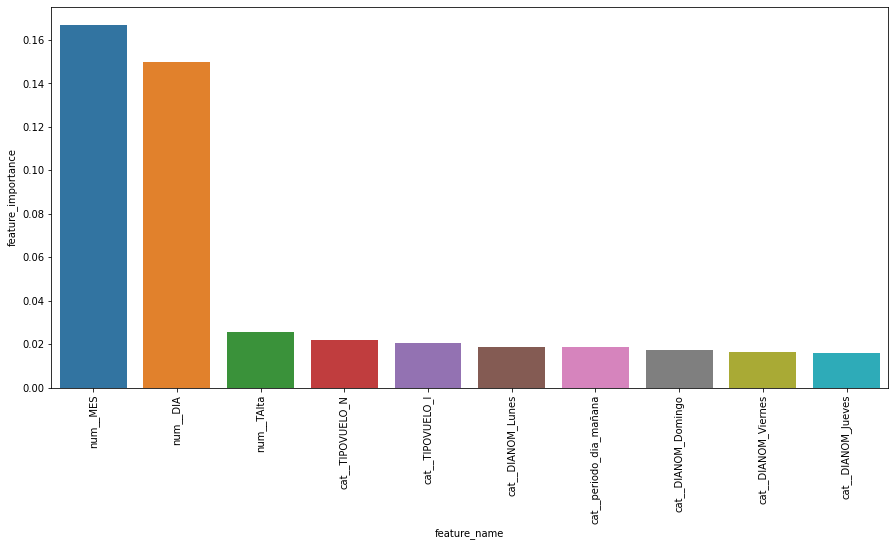

In [59]:
plt.figure(figsize = (15,7))
sns.barplot(data = feature_importance_data.sort_values(by='feature_importance', ascending = False).head(10), x='feature_name', y='feature_importance')
plt.xticks(rotation = 90);

In [ ]:
# WandB Logs
name = "baseline:v1"
tags = ["LogisticRegression", "ClassWeights"]

# Init run
run = wandb.init(project="bice-test", entity="diegulio", name = name, tags = tags)

# logs
log_wandb(run, f1, auc, test_preds, test_probs, model, X_base_train, y_train, X_base_test, y_test)

# Finish Run
run.finish()

# Baseline + FE : RandomForest + FE

In [ ]:
X_train

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:

# Logistic Regression
rf = RandomForestClassifier(class_weight='balanced', random_state=cfg.seed)

# Pipeline

# Numeric Transformer
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

# Categorical Transformer
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Feature Processor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", rf)]
)
# RandomSearch Grid
tf_param_grid = {
    "model__max_depth": [10, 50, 100, 500],
    "model__n_estimators": [10, 50, 100, 500],
    #"model__min_weight_fraction_leaf" : np.logspace(-4, 4, 10)

}

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61385 entries, 40166 to 58693
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Vlo-I        61385 non-null  object
 1   Des-I        61385 non-null  object
 2   Emp-I        61385 non-null  object
 3   DIA          61385 non-null  int64 
 4   MES          61385 non-null  int64 
 5   DIANOM       61385 non-null  object
 6   TIPOVUELO    61385 non-null  object
 7   OPERA        61385 non-null  object
 8   SIGLADES     61385 non-null  object
 9   TAlta        61385 non-null  int64 
 10  periodo_dia  58599 non-null  object
dtypes: int64(3), object(8)
memory usage: 5.6+ MB


In [ ]:
for col in X_train.columns:
  if col in cat_cols:
    X_train[col] = X_train[col].astype(str)
  if col in num_cols:
    X_train[col] = X_train[col].astype('int32')

In [ ]:
r_search = RandomizedSearchCV(pipe, tf_param_grid, n_jobs=2, verbose = 1, scoring='f1', cv = cfg.Kfold, random_state=cfg.seed)
r_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
print("Best parameter (CV score=%0.3f):" % r_search.best_score_)
print(r_search.best_params_)

In [ ]:
test_preds = r_search.predict(X_test)
test_probs = r_search.predict_proba(X_test)
model = r_search.best_estimator_

===== F1 Score =====
Test Score: 0.416
===== AUC Score =====
AUC Score: 0.704
===== Confusion Matrix =====


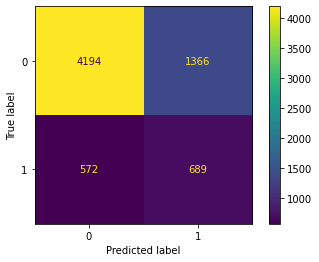

In [ ]:
f1, auc, cm = display_metrics(y_test, test_preds, test_probs)

In [ ]:
# Feature Importance
import sklearn
# Primero debo fitear el column transformer para obtener los nombres de las variables
X_temp = preprocessor.fit_transform(X_train)
feature_names = get_feature_names(preprocessor)

# Feature Importance
feature_importance = model['model'].feature_importances_

# Create DataFrame
feature_importance_data = pd.DataFrame(data={'feature_name': feature_names, 'feature_importance':feature_importance})

<ipython-input-24-8dbcb727e223>:51: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


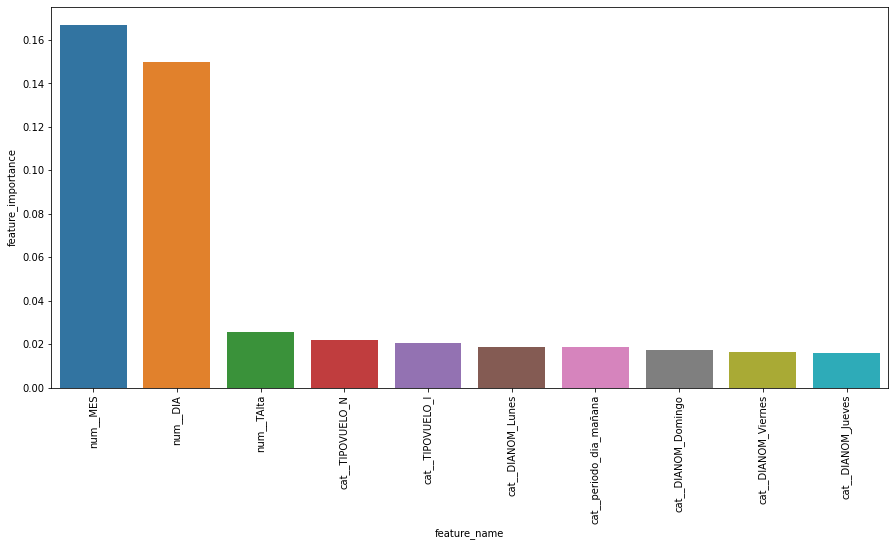

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(data = feature_importance_data.sort_values(by='feature_importance', ascending = False).head(10), x='feature_name', y='feature_importance')
plt.xticks(rotation = 90);

In [ ]:
# WandB Logs
name = "baseline:v1"
tags = ["LogisticRegression", "ClassWeights"]

# Init run
run = wandb.init(project="bice-test", entity="diegulio", name = name, tags = tags)

# logs
log_wandb(run, f1, auc, test_preds, test_probs, model, X_base_train, y_train, X_base_test, y_test)

# Finish Run
run.finish()